# Zebra finch dataset

This dataset contains neural recordings from the songbird motor nucleus RA and audio recordings of birdsong, collected by grad students here at UCSD!

Zebra finches sing a very repetitive song consisting of repeated *motifs* (you'll see why this is useful later). A fixed sequence of syllables makes up a motif, and a sequence of motifs make up a single bout of song. They'll also often sing a few intro notes before the song.

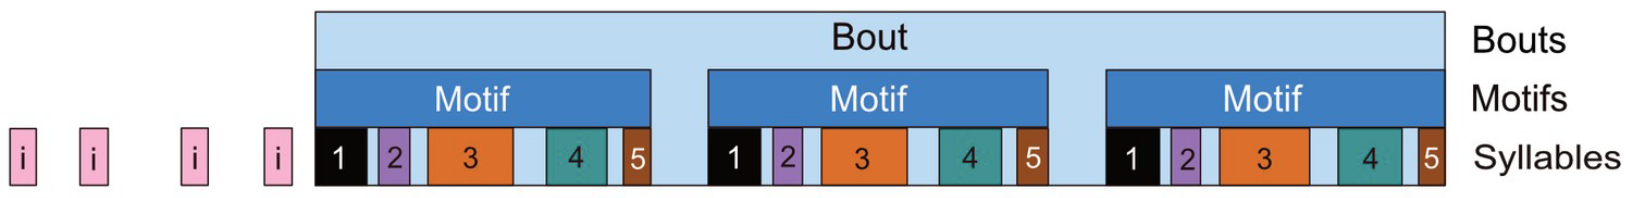

Nucleus RA projects to muscles in the vocal organ of songbirds, similar to how primary motor cortex projects to muscles in humans and monkeys. We recorded neurons in nucleus RA, with the hypothesis that activity in RA could tell us about the song the bird was singing.

- This zebra finch was implanted with a Neuropixels probe targeting RA
- After the bird recovered from the surgery, it was recorded while singing freely
- The song it produced and simultaneous activity in RA are provided in this notebook.

Walk through the code and recreate the figures, and then see what else you can do with the data!

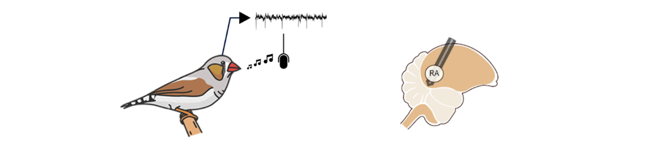

---
# Setup

In [ ]:
# @title Import packages
import numpy as np
import pandas as pd
import pickle
import copy
from scipy import stats
from scipy.io import loadmat, wavfile
from scipy.signal import filtfilt, spectrogram
from scipy.signal.windows import gaussian
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
# @title Data loading functions

# Load filter coefficients
def load_filter_coefficients(file_path):
    coefficients = loadmat(file_path)
    a = coefficients['a'][0]
    b = coefficients['b'][0]
    return b, a

# Read wav file
def read_wav_chan(wav_path: str, chan_id: int=0) -> tuple:
    s_f, x = wavfile.read(wav_path, mmap=True)
    if x.ndim==1:
        if chan_id > 0:
            raise ValueError('Wave file has only one channel, asking for channel {}'.format(chan_id))
        x = x.reshape(-1, 1)
    return s_f, x[:, chan_id]

In [ ]:
# @title Signal processing functions

# Perform noncausal filter
def noncausal_filter(x, b, a=1):
    y = filtfilt(b, a, x)
    return y


# Get all of the spikes within a window of time:
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample

    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, "neither")]

    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr


# Get the spike rasters
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1) # returns np.array([n_clu, n_sample, n_trial])


# Get the all of the motifs for which we have calculated the rasters:
def get_window_audio(wav_mic_npy, start_sample_list, span_samples):
    audio_arr_list = [wav_mic_npy[start_sample_list[i] : start_sample_list[i]+span_samples] for i in range(len(start_sample_list))]
    return(np.array(audio_arr_list).squeeze().tolist())


# Compute spectrogram
def ms_spectrogram(x, s_f, n_window=512, step_ms=1, f_min=100, f_max=9000, cut_off=0.000055):

    # the overlap is the size of the window minus the samples in a msec
    msec_samples = int(s_f * 0.001)
    n_overlap = n_window - msec_samples * step_ms
    sigma = 1 / 200. * s_f

    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f,
                            nperseg=n_window,
                            noverlap=n_overlap,
                            window=gaussian(n_window, sigma),
                            scaling='spectrum')

    if cut_off > 0:
        Sxx[Sxx < np.max((Sxx) * cut_off)] = 1

    Sxx[f<f_min, :] = 1

    return f[(f>f_min) & (f<f_max)], t, Sxx[(f>f_min) & (f<f_max)]


# Return binned vector according to bin size (Input: 1D list)
def downsample_list_1d(dat, number_bin_samples, mode='sum'):
    """"
     Downsamples (bins) a 1D-list acording to selected number of bin samples.

     Input: dat[1 x Samples]
     number_bin_samples = Number of samples in each bin (bin size in samples).
     mode: 'sum', 'mean', 'mode' (downsample summing, averaging or taking the mode of all samples)

     Output: [1 x Samples]
    """
    assert mode in ['sum', 'mean', 'mode'], "Mode type must be 'sum', 'mean', or 'mode', default is 'sum'"

    if mode == 'sum':
        return np.sum(np.array(dat[:(len(dat) // number_bin_samples) * number_bin_samples]).reshape(-1, number_bin_samples), axis=1)

    elif mode == 'mean':
        return np.mean(np.array(dat[:(len(dat) // number_bin_samples) * number_bin_samples]).reshape(-1, number_bin_samples), axis=1)

    elif mode == 'mode':
        return stats.mode(np.array(dat[:(len(dat) // number_bin_samples) * number_bin_samples]).reshape(-1, number_bin_samples), axis=1)[0].reshape(-1)

---
# Load data

In [ ]:
# @title Download data
# !pip install wget

!wget -O ../Datasets/zebra_finch/clu_df_ra.pkl https://www.dropbox.com/scl/fi/gk1skqya40nbo515r8362/clu_df_ra.pkl?rlkey=ukmz1nm8l5ofwft64m3226hlp&dl=0
!wget -O filt_coeffs.mat https://www.dropbox.com/scl/fi/4pd17n8d6blawuqzfb36l/filt_coeffs.mat?rlkey=fmhrgu2bp9edb59vjxm1i1dzx&dl=0
!wget -O handlabels.pkl https://www.dropbox.com/scl/fi/ji45nne6v12cm3kbmvaz2/handlabels.pkl?rlkey=vo64y2bshwrbioehqr70l694d&dl=0
!wget -O mot_dict.pkl https://www.dropbox.com/scl/fi/gzbdsxsyslo048gutbi4j/mot_dict.pkl?rlkey=vqr2z494o0gp0m0hqciz0xoz9&dl=0
!wget -O spk_df.pkl https://www.dropbox.com/scl/fi/u6vrva41tzm3nqkop3so8/spk_df.pkl?rlkey=eax4h7bywbq7reqh693m5izp7&dl=0
!wget -O wav_mic.wav https://www.dropbox.com/scl/fi/znp78zepaq41j5lnd5m1k/wav_mic.wav?rlkey=tcg3scbtxqd1yhvyk7wbcce56&dl=0

## Load audio

In [ ]:
# Load audio data from wav file
wav_path = '/content/wav_mic.wav'
s_f_wav, mic_stream = read_wav_chan(wav_path)
b, a = load_filter_coefficients('/content/filt_coeffs.mat')
mic_stream_hp =  noncausal_filter(mic_stream, b, a=a)

In [ ]:
# Load hand-labeled syllable IDs
labels_pickle_path = '/content/handlabels.pkl'
with open(labels_pickle_path, 'rb') as f:
    handlabels = pickle.load(f)

## Load neural data

In [ ]:
# Load spike dataframe, cluster dataframe, and motif dictionary
spike_pickle_path = '/content/spk_df.pkl'
clu_pickle_path = '/content/clu_df_ra.pkl'
mot_dict_path = '/content/mot_dict.pkl'

In [ ]:
with open(spike_pickle_path, 'rb') as f:
    spk_df = pd.read_pickle(f)

with open(clu_pickle_path, 'rb') as f:
    clu_df = pd.read_pickle(f)

with open(mot_dict_path, 'rb') as f:
    mot_dict = pd.read_pickle(f)

In [ ]:
# Record sampling rates for audio and neural data (don't worry, we handle syncing later!)
fs_ap = int(mot_dict['s_f_ap_0'])
fs_audio = int(mot_dict['s_f'])

print('Neural sampling rate:', fs_ap)
print('Audio sampling rate:', fs_audio)

In [ ]:
# Let's see how many neurons we've identified in RA
print('RA neurons:', len(np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['ISILabel']=='good'), 'cluster_id'])))

# Visualize data

In [ ]:
# @title Data processing functions

def get_spiking_neurons(neurons_array):
    mean_fr_neurons = np.mean(np.sum(neurons_array, 1), 1)
    return np.where(mean_fr_neurons>0)[0]

def get_spiking_neurons_above_rate(neurons_array: np.array, fs: int=30000, min_rate: int=1) -> np.array:
    mean_fr_neurons = np.mean(np.sum(neurons_array, 1), 1)  / (neurons_array.shape[1] / fs)
    return np.where(mean_fr_neurons > min_rate)[0]

In [ ]:
# @title Plotting functions

def find_label_edges(traj_labels):
    ''' Find indexes in a vector of labels [1 x labels] where a change of label occurs.
    fnx(np.where) indicates the index of the last number before a change occurs, so we add 1 to the index vector.
    Add index 0 and last index (len(mot)) for plotting purposes.'''
    lbl_edges = np.where(np.diff(traj_labels))[0] + 1
    lbl_edges = np.insert(lbl_edges, 0, 0)
    lbl_edges = np.append(lbl_edges, len(traj_labels))
    return lbl_edges

def plot_behavioral_raster(audio_trial, audio_labels, labels_trial, colors, ax, fontsize=20):
    lbl_edges = find_label_edges(labels_trial)
    for idx in range(len(lbl_edges) -1 ):
        plt_color = colors[labels_trial[lbl_edges[idx]]] # color based on label for this segment
        start_time = lbl_edges[idx] # plot starting at the end of the previous segment (except if first segment)
        end_time = lbl_edges[idx+1] + 1 if idx !=  len(lbl_edges) - 2 else lbl_edges[idx+1] # plot samples until the start of the next segment
        x_linspace = list(range(start_time, end_time))
        ax[0].hlines(y = len(audio_labels), xmin=x_linspace[0], xmax=x_linspace[-1], linewidth=40, color=plt_color)
        ax[1].plot(x_linspace , audio_trial[ start_time:end_time ], linewidth=2, color=plt_color)
    ax[0].set_xlim([0, len(audio_trial)])
    ax[0].set_axis_off()
    ax[1].set_xlim([0, len(audio_trial)])
    ax[1].spines.right.set_visible(False)
    ax[1].spines.top.set_visible(False)
    ax[1].spines.bottom.set_visible(False)
    ax[1].spines.left.set_visible(False)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_ylabel('Amplitude \n a.u.', fontsize=fontsize)

def plot_spectrogram(t, f, sxx, ax, fontsize=20, tickfontsize=14):
    ax.pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax.xaxis.set_visible(False)
    ax.set_ylabel('f (kHz)', fontsize=fontsize)
    ax.set_yticks([2000, 4000, 6000, 8000])
    ax.set_yticklabels(['2', '4', '6', '8'], fontsize=tickfontsize);

def plot_spike_raster(x, ax, s=7, fontsize=20):
    x_array = copy.deepcopy(x)
    n_y, n_t = x_array.shape

    row = np.ones(n_t)
    t = np.arange(n_t)
    col = np.arange(n_y)

    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x_array[x_array==0] = np.nan

    raster = ax.scatter(t * x_array, frame * x_array, marker='.', facecolor='black', s=s, rasterized=False)
    ax.set_xlim([0, n_t])

    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_ylabel('Neuron raster', fontsize=fontsize);

def plot_average_firing_rate(neuron_raster, ax, bin_ms=20, fontsize=14):
    bin_samples_spikes = round(bin_ms/1000 * fs_ap)
    fr = downsample_list_1d(np.sum(neuron_raster, 0), bin_samples_spikes, mode='mean')
    ax.plot(fr / (bin_ms/1000), color=(72/256, 61/256, 139/256), linewidth=2)

    # standard deviation
    std_dev = downsample_list_1d(np.std(neuron_raster, 0), bin_samples_spikes, mode='mean')
    ax.fill_between(range(len(fr)), (fr - 2 * std_dev) / (bin_ms/1000), (fr + 2 * std_dev) / (bin_ms/1000), color=(72/256, 61/256, 139/256), alpha=0.3)

    ax.set_ylabel('Average firing rate\n(spikes/s)', fontsize=fontsize)
    ax.set_xlim([0, len(fr)])
    ax.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [ ]:
# @title Set syllable colors
# Set colors for our labels
colors = {1:'#000000', # syllable 1
          2:'#B67FED', # syllable 2
          3:'#C06E1B', # syllable 3
          4:'#128080', # syllable 4
          5:'#804912', # syllable 5
          6:'#286DB6', # syllable 6
          7:'#D3D3D3', # syllable 7
          8:'#D3D3D3', # motif silence
          9:'#349946', # intra-motif note
          10:'#FEB4D9', # intro note
          11:'#FFFF6D', # calls
          12:'#00FFFF', # unlabeled
          13:'#EBEBEB', # silence
          14:'#EBEBEB'}

## Let's plot a bout of song

In [ ]:
mot_idx = 0 # let's start with the first motif

# Time points (the first black syllable in the figure below is time 0)
t_pre = -0.34
t_post = 4.21

# Neural buffer
t_pre_samp = int(t_pre * fs_ap)
t_post_samp = int(t_post * fs_ap)

# Audio buffer
fs_audio = mot_dict['s_f']
t_pre_samp_audio = int(t_pre * fs_audio)
t_post_samp_audio = int(t_post * fs_audio)

# Start indices
mot_start_wav = mot_dict['start_sample_wav_aligned'][mot_idx]
mot_start_ap = mot_dict['start_sample_ap_0_aligned'][mot_idx]

# Audio
mic_arr = mic_stream_hp[mot_start_wav + t_pre_samp_audio: mot_start_wav + t_post_samp_audio]
f, t, sxx = ms_spectrogram(mic_arr.flatten(), s_f_wav)

# Labels
audio_labels = handlabels[mot_start_wav + t_pre_samp_audio: mot_start_wav + t_post_samp_audio]

In [ ]:
# Get the neural data for this bout of song
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['ISILabel']=='good'), 'cluster_id'])
rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0_aligned'] + t_pre_samp, t_post_samp - t_pre_samp) # neurons x time x epochs

In [ ]:
# Let's only use the neurons spiking above a certain rate (1.2 Hz)
spiking_n = get_spiking_neurons_above_rate(rast_arr, fs=fs_ap, min_rate=1.2)
rast_arr_high_spikes = rast_arr[spiking_n]
print(f'{np.shape(rast_arr_high_spikes)[0]} spiking neurons')

In [ ]:
# First let's extract the exact segment of song we want to plot
t_start_plot_samp_audio = 0
t_end_plot_samp_audio = int((t_post-t_pre)*fs_audio)
audio_trial = np.array(mic_arr[t_start_plot_samp_audio:t_end_plot_samp_audio])
f, t, sxx = ms_spectrogram(audio_trial, s_f_wav)
labels_trial = np.array(audio_labels[t_start_plot_samp_audio:t_end_plot_samp_audio])

# Now let's create the figure
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [0.7, 3, 3]}, figsize=(20, 4))
plt.subplots_adjust(hspace=0.07)

# Behavioral raster
plot_behavioral_raster(audio_trial, audio_labels, labels_trial, colors, ax)

# Spectrogram
plot_spectrogram(t, f, sxx, ax[2]);

## Nice! Let's add some neural data to this figure

In [ ]:
# Neural data
t_start_plot_samp = 0
t_end_plot_samp = int((t_post-t_pre)*fs_ap)
neuron_raster = rast_arr_high_spikes[:, t_start_plot_samp:t_end_plot_samp, mot_idx]

# Create the figure
fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [0.7, 3, 3, 20]}, figsize=(20, 20))
plt.subplots_adjust(hspace=0.07)

# Behavioral raster
plot_behavioral_raster(audio_trial, audio_labels, labels_trial, colors, ax[:2])

# Spectrogram
plot_spectrogram(t, f, sxx, ax[2]);

# Spike raster
plot_spike_raster(neuron_raster, ax[3])

## It looks like there's a pattern to the way the neurons are firing. Let's plot the average firing rate in RA

In [ ]:
# Create the figure
fig, ax = plt.subplots(nrows=5, gridspec_kw={'height_ratios': [0.7, 3, 3, 4, 20]}, figsize=(20, 24))
plt.subplots_adjust(hspace=0.07)

# Behavioral raster
plot_behavioral_raster(audio_trial, audio_labels, labels_trial, colors, ax[:2])

# Spectrogram
plot_spectrogram(t, f, sxx, ax[2]);

# Average firing rate w/ standard deviation
plot_average_firing_rate(neuron_raster, ax[3], bin_ms=20)

# Spike raster
plot_spike_raster(neuron_raster, ax[4])

---
# Song "trials"

As you've probably noticed, zebra finch song contains syllables in the song repeat multiple times in the same order (called motifs). This bird sings a motif that we've labeled black-purple-orange-teal-brown, some pink intro notes at the beginning of his song, and sometimes sings some extra green notes in the middle of his song. Let's take advantage of these song motif "trials" to plot some single neuron responses.

In [ ]:
# Our motif dictionary has the start indices for all the black syllables in this recording session
for i, mot in enumerate(mot_dict['start_sample_wav_aligned']):
    print('Syllable '+str(i)+': start index',mot)

Note that the song we've been plotting contains syllables #0-5. There's another song we haven't plotted yet, containing syllables #6-9

In [ ]:
# Let's write a helper function to extract the motif information we need
def get_motif(mot_idx, t_pre=-0.02, t_post=0.5):
    # Audio buffer
    fs_audio = mot_dict['s_f']
    t_pre_samp_audio = int(t_pre * fs_audio)
    t_post_samp_audio = int(t_post * fs_audio)

    # Start index
    mot_start_wav = mot_dict['start_sample_wav_aligned'][mot_idx]

    # Audio
    mic_arr = mic_stream_hp[mot_start_wav + t_pre_samp_audio: mot_start_wav + t_post_samp_audio]
    f, t, sxx = ms_spectrogram(mic_arr.flatten(), s_f_wav)

    # Labels
    audio_labels = handlabels[mot_start_wav + t_pre_samp_audio: mot_start_wav + t_post_samp_audio]

    # Motif
    t_start_plot_samp_audio = 0
    t_end_plot_samp_audio = int((t_post-t_pre)*fs_audio)
    audio_trial = np.array(mic_arr[t_start_plot_samp_audio:t_end_plot_samp_audio])
    f, t, sxx = ms_spectrogram(audio_trial, s_f_wav)
    labels_trial = np.array(audio_labels[t_start_plot_samp_audio:t_end_plot_samp_audio])

    return audio_trial, audio_labels, labels_trial, t, f, sxx

In [ ]:
# Create a figure of all song motifs:
n_motifs = len(mot_dict['start_sample_wav_aligned'])
h_ratios = [0.5, 2, 3, 1]
fig, ax = plt.subplots(nrows=4*n_motifs, gridspec_kw={'height_ratios':h_ratios*n_motifs}, figsize=(5, 15))
plt.subplots_adjust(hspace=0.07)

print(f'This bird sang {n_motifs} motifs:')
for i,_ in enumerate(mot_dict['start_sample_wav_aligned']):
    row_idx = i*4
    audio_trial, audio_labels, labels_trial, t, f, sxx = get_motif(i)
    # Behavioral raster
    plot_behavioral_raster(audio_trial, audio_labels, labels_trial, colors, ax[row_idx:row_idx+2])
    # Spectrogram
    plot_spectrogram(t, f, sxx, ax[row_idx+2]);
for a in ax: a.axis('off')

## Now let's pick a single neuron and plot its activity over these 10 trials

In [ ]:
# Let's write a helper function to extract single neuron trials
def get_single_neuron(raster, neuron_idx, fs_ap=fs_ap, t_pre=-0.02, t_post=0.5):
    neuron_raster = raster[neuron_idx, 0:int((t_post-t_pre)*fs_ap), :]

    return neuron_raster

In [ ]:
# Pick a single neuron by index
n = 65

# Create the figure
fig, ax = plt.subplots(nrows=6, gridspec_kw={'height_ratios': [0.5, 2, 3, 0.5, 4, 4]}, figsize=(8, 8))#, constrained_layout=True)

# Get motif data
audio_trial, audio_labels, labels_trial, t, f, sxx = get_motif(0)
# Behavioral raster
plot_behavioral_raster(audio_trial, audio_labels, labels_trial, colors, ax[:2], fontsize=14)
# Spectrogram
plot_spectrogram(t, f, sxx, ax[2], fontsize=14, tickfontsize=10);

# Empty white space
ax[3].set_axis_off()

# Single neuron rasters
one_neuron_spikes = get_single_neuron(rast_arr_high_spikes, n)
one_neuron_spikes = np.flip(one_neuron_spikes, axis=1)
plot_spike_raster(one_neuron_spikes.T, ax[4], s=25)
ax[4].set_ylabel(f'Neuron {n}', fontsize=14)
ax[4].set_title(f'{n_motifs} trials', loc='right', fontsize=14)

# Firing rate
plot_average_firing_rate(one_neuron_spikes.T, ax[5], bin_ms=5, fontsize=10)

## Try plotting some other neurons and see what the responses look like
(Hint: neurons 52, 56, 59, 60, and 61 look interesting. And there are a lot more!)

---
# Now let's run some dimensionality reduction to estimate latent neural trajectories from our data

What's dimensionality reduction? What's a neural trajectory? Basically we can take high dimensional dataset (number of neurons) x (number of samples) and transform it into lower dimensional dataset while retaining as much information as possible. Sort of like this...

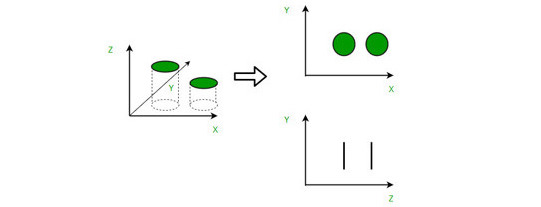

Higher dimension --> lower dimension

We'll use Gaussian Process Factor Analysis (**GPFA**), a method that applies (1) factor analysis to time-binned spike count data to reduce the dimensionality and at the same time (2) smoothes the resulting low-dimensional trajectories by fitting a Gaussian process model to them.

In [ ]:
# Import packages
!pip install elephant
from elephant.gpfa import GPFA
import quantities as pq
import neo

In [ ]:
# Specify model fitting parameters
bin_size_ms = 15 # 15 ms bins
bin_size = bin_size_ms * pq.ms
latent_dimensionality = 3 # 3 dimensions
gpfa = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [ ]:
# Format data for GPFA
t_pre=-0.02; t_post=0.5; t_stop=t_post-t_pre
neuron_raster = rast_arr_high_spikes[:, 0:int((t_post-t_pre)*fs_ap), :] # neuron x time x trial

neo_spiketrains = [] # list of list of neo.SpikeTrains
# outer list corresponds to trials and the inner list corresponds to neurons
# such that neo_spiketrains[1][n] is the spike train of neuron n in trial l
for trial_idx in range(np.shape(neuron_raster)[2]):
    neo_spiketrains_per_trial = []
    for neuron_idx in range(np.shape(neuron_raster)[0]):
        spike_indices = np.nonzero(neuron_raster[neuron_idx,:,trial_idx])[0]
        spike_times = spike_indices / fs_ap
        nst = neo.SpikeTrain(spike_times, units='sec', t_stop=t_stop)
        neo_spiketrains_per_trial.append(nst)
    neo_spiketrains.append(neo_spiketrains_per_trial)

In [ ]:
# Fit the model, using half of the trials for fitting
gpfa.fit(neo_spiketrains[:len(neo_spiketrains) // 2])
print(gpfa.params_estimated.keys())

In [ ]:
# Transform the other half of the trials into neural tranjectories
trajectories = gpfa.transform(neo_spiketrains[len(neo_spiketrains) // 2:])

# Visualize neural trajectories

In [ ]:
# Let's start by plotting the first 2 dimensions
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Neural trajectories')
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_aspect(1)

# Single trial trajectories
for single_trial_trajectory in trajectories:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=0.5, c='indigo', alpha=0.5)
# Trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax.plot(average_trajectory[0], average_trajectory[1], '-', lw=2, c='indigo', label='Average trajectory')
ax.legend()
plt.tight_layout()
plt.show()

Nice! It looks like the neural trajectory takes a similar path through 2D space every time the bird sings that motif! That makes sense, because the nucleus RA that we're recording from projects to the vocal muscles of the bird, so we would expect similar activity patterns in RA every time the bird sings the motif.

In [ ]:
# Now let's plot all 3 dimensions
import plotly.graph_objects as go
fig = go.Figure()
for i, single_trial_trajectory in enumerate(trajectories):
    fig.add_trace(go.Scatter3d(x=single_trial_trajectory[0],
                               y=single_trial_trajectory[1],
                               z=single_trial_trajectory[2],
                               mode='lines', name=f'Trajectory {i}', showlegend=False))
fig.update_layout(width=600, height=500, scene=dict(aspectmode="cube"))
fig.update_layout(scene=dict(xaxis_title='Factor 1', yaxis_title='Factor 2', zaxis_title='Factor 3'))
fig.show()

---
# The data are provided below, formatted into a dataframe for you to work with

Remember our plotting functions:

- `plot_behavioral_raster(audio_trial, audio_labels, labels_trial, colors, ax)`

- `plot_spectrogram(t, f, sxx, ax)`

- `plot_spike_raster(spiketrain, ax)`

- `plot_average_firing_rate(spiketrain, ax)`

In [ ]:
# fs_ap: neural sampling rate
# fs_audio: audio sampling rate
print('Neural sampling rate:', fs_ap)
print('Audio sampling rate:', fs_audio)

# data: dataframe containing all 10 trials
trialized_data = pd.DataFrame([
    {
        'spiketrain': np.squeeze(neuron_raster[:, :, i]),
        'audio_trial': audio_trial,
        'audio_labels': audio_labels,
        'labels_trial': labels_trial,
        't': t,
        'f': f,
        'sxx': sxx
    }
    for i, (audio_trial, audio_labels, labels_trial, t, f, sxx) in enumerate(
                    map(get_motif, range(np.shape(neuron_raster)[2])))
])
print('All trials:')
trialized_data.head(3)

## Let's practice working with the dataframe

In [ ]:
# Plot the average firing rate of all neurons for motif 1
fig, ax = plt.subplots(figsize=(10,5))
plot_average_firing_rate(..., ax)

In [ ]:
# @title Show for solution
# fig, ax = plt.subplots(figsize=(10,5))
# plot_average_firing_rate(trialized_data['spiketrain'][0], ax)

In [ ]:
# Now plot the average firing rate of a single neuron for all motifs
n_trials = len(trialized_data)
n_neurons = np.shape(trialized_data['spiketrain'][0])[0]
n_samples = np.shape(trialized_data['spiketrain'][0])[1]

neuron_idx = 65
single_neuron_spike_trains = np.empty([n_trials, n_samples])
# now generate the single neuron spike trains...
for i in range(n_trials):
    single_neuron_spike_trains[i,:] = ...
fig, ax = plt.subplots(figsize=(10,5))
plot_average_firing_rate(single_neuron_spike_trains, ax)

In [ ]:
# @title Show for solution
# n_trials = len(trialized_data)
# n_neurons = np.shape(trialized_data['spiketrain'][0])[0]
# n_samples = np.shape(trialized_data['spiketrain'][0])[1]
#
# neuron_idx = 65
# single_neuron_spike_trains = np.empty([n_trials, n_samples])
# for i in range(n_trials):
#     single_neuron_spike_trains[i,:] = trialized_data['spiketrain'][i][neuron_idx,:]
# fig, ax = plt.subplots(figsize=(10,5))
# plot_average_firing_rate(single_neuron_spike_trains, ax)


## you could also do it like this!
# n_trials = len(trialized_data)
# n_neurons = np.shape(trialized_data['spiketrain'][0])[0]
# n_samples = np.shape(trialized_data['spiketrain'][0])[1]
#
# neuron_idx = 65
# single_neuron_spike_trains = get_single_neuron( # use our get_single_neuron function from before
#     np.stack(trialized_data['spiketrain'].to_list(), axis=2),
#     neuron_idx).T
# fig, ax = plt.subplots(figsize=(10,5))
# plot_average_firing_rate(single_neuron_spike_trains, ax)

# Now see what you can come up with!

Here are some ideas to get you started:
- Do different neurons fire differently when producing the song? Try plotting the average firing rate of different neurons across trials
- Do different neurons seem to respond to certain parts of the song (like singing onset or offset)? Do different neurons seem to respond to certain syllables?

**Bonus!**
- Is 3 dimensions the right number for GPFA? What happens if you try a different number of dimensions?